In [1]:
import torch, torchvision
from torch.utils.cpp_extension import CUDA_HOME; 

#check versions and CUDA
print(torch.__version__)
!gcc --version
print(torch.version.cuda)
print(torch.cuda.is_available(), CUDA_HOME)

1.8.1
gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-44)
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

10.1
True /usr/local/cuda


In [2]:
#!python -m detectron2.utils.collect_env

In [3]:
import sys
sys.path

['/camp/lab/briscoej/working/tiago/nucleus_t18/Nucleus/notebooks',
 '/camp/lab/briscoej/working/tiago/nucleus_t18/nucleys_t18/lib/python37.zip',
 '/camp/lab/briscoej/working/tiago/nucleus_t18/nucleys_t18/lib/python3.7',
 '/camp/lab/briscoej/working/tiago/nucleus_t18/nucleys_t18/lib/python3.7/lib-dynload',
 '',
 '/camp/home/ritot/.local/lib/python3.7/site-packages',
 '/camp/lab/briscoej/working/tiago/nucleus_t18/nucleys_t18/lib/python3.7/site-packages',
 '/camp/lab/briscoej/working/tiago/nucleus_t18/nucleys_t18/lib/python3.7/site-packages/IPython/extensions',
 '/camp/home/ritot/.ipython']

In [4]:
sys.executable

'/camp/lab/briscoej/working/tiago/nucleus_t18/nucleys_t18/bin/python'

In [5]:
# there is a detectron wrong version somwhr.. make sure path is only the env one

# sys.path.remove('/camp/lab/briscoej/working/tiago/nucleus_test1/Nucleus/notebooks')
sys.path.remove('/camp/home/ritot/.local/lib/python3.7/site-packages')
sys.path.remove('/camp/home/ritot/.ipython')
sys.path.remove('')

In [6]:
%load_ext autoreload
%autoreload 2

# import common libraries
import numpy as np
import cv2
import os
import random
import matplotlib.pylab as plt
from PIL import Image
import tqdm 
import timeit

# import some detectron2 utilities
import detectron2
print(detectron2.__version__)
import sys
sys.path.append('../')

from Nucleus import ImageInput
from Nucleus import ImageTile
from Nucleus import Stitcher
from detectron2_predict import detectron_predict
from detectron2_predict import detectron_init
from utils import PNG_to_JSON
from Nucleus import coco_nucleus
from skimage import io
import tifffile

0.4
Nucleus
utils.PNG_to_JSON


# Step 1: get segmentation for all images

1. Pick a single z-plane (if fine z-stack was aquired probably 2-3 planes can be collapsed in a max projection but bear in mind the algorithm was trained on images that do not have overlapping nuclei).

2. Size should multiple of 128 - now there is a check that ensures this by generating a cropped version. 


In [7]:
os.getcwd()

'/camp/lab/briscoej/working/tiago/nucleus_t18/Nucleus/notebooks'

In [8]:
#ROOT_PATH = '/camp/lab/briscoej/working/frith/confocal/JBBM/Z4T_MARCH/ISL1_FOXP1_LHX3/'
# ROOT_PATH = '/camp/lab/briscoej/working/frith/confocal/JBBM/Z4T_MARCH/ISLS_LIM3/'
# /working/frith/confocal/JBBM/Z4T_MARCH/LIM1_FOXP1
# /working/frith/confocal/JBBM/Z4T_MARCH/LIM1_ISL1_MECOM
# /working/frith/confocal/JBBM/Z4T_MARCH/OLIG2  
# /working/frith/confocal/JBME/Z4T_MARCH/Z4T/OLIG2_ISL1
# /working/frith/confocal/JBME/Z4T_MARCH/Z4T/OLIG_PAX_NKX
# /working/frith/confocal/JCBR/E11.5/Z4T_JCBR39_MAR22/
# /working/frith/confocal/JBBM/Z4T_MARCH/THOR_DAPI_ISL1_LHX3

ROOT_PATH = '/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/'
os.listdir(ROOT_PATH)
os.mkdir(ROOT_PATH+"/img")
os.mkdir(ROOT_PATH+"/masks")

In [9]:
import glob
import shutil
dest_dir = ROOT_PATH+"img"
for file in glob.glob(ROOT_PATH+'*.tif'):
    print(file)
    shutil.move(file, dest_dir)

/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/04-08-22_40x.lif - scram-3 - Z=8.tif
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/04-08-22_40x.lif - scram-4 - Z=7.tif
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/04-08-22_40x.lif - scram-1 - Z=4.tif
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/04-08-22_40x.lif - olig2-2 - Z=1.tif
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/04-08-22_40x.lif - olig2-4 - Z=2.tif
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/04-08-22_40x.lif - scram-4 - Z=3.tif
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/04-08-22_40x.lif - scram-2 - Z=3.tif
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/04-08-22_40x.lif - olig2-1 - Z=5.tif
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/04-08-22_40x.lif - olig2-4 - Z=0.tif
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/

In [10]:
#ROOT_PATH = "/camp/lab/briscoej/working/frith/confocal/z4tiago/" 


#ROOT_PATH = "/camp/lab/briscoej/working/tiago/dmel_segm/" 
#there should be a img and masks folders inside ROOT_PATH.

NUCLEAR_Ch = 0 # zero-indexed => 0 corresponds to channel 1

#lists all images to be segmented
images_to_segment = os.listdir(ROOT_PATH+"img/")
print(images_to_segment)

['04-08-22_40x.lif - scram-3 - Z=8.tif', '04-08-22_40x.lif - scram-4 - Z=7.tif', '04-08-22_40x.lif - scram-1 - Z=4.tif', '04-08-22_40x.lif - olig2-2 - Z=1.tif', '04-08-22_40x.lif - olig2-4 - Z=2.tif', '04-08-22_40x.lif - scram-4 - Z=3.tif', '04-08-22_40x.lif - scram-2 - Z=3.tif', '04-08-22_40x.lif - olig2-1 - Z=5.tif', '04-08-22_40x.lif - olig2-4 - Z=0.tif', '04-08-22_40x.lif - olig2-3 - Z=2.tif (MG).tif', '04-08-22_40x.lif - scram-2 - Z=8.tif', '04-08-22_40x.lif - olig2-3 - Z=2.tif', '04-08-22_40x.lif - olig2-1 - Z=0.tif', '04-08-22_40x.lif - scram-1 - Z=6.tif', '04-08-22_40x.lif - olig2-4 - Z=4.tif', '04-08-22_40x.lif - olig2-4 - Z=3.tif (G).tif', '04-08-22_40x.lif - olig2-3 - Z=2.tif (RGB).tif', '04-08-22_40x.lif - scram-4 - Z=0.tif', '04-08-22_40x.lif - olig2-1 - Z=4.tif', '04-08-22_40x.lif - scram-4 - Z=5.tif', '04-08-22_40x.lif - scram-2 - Z=2.tif', '04-08-22_40x.lif - olig2-3 - Z=4.tif', '04-08-22_40x.lif - scram-4 - Z=6.tif', '04-08-22_40x.lif - olig2-5 - Z=6.tif', '04-08-22_40

In [11]:
input_img=images_to_segment[17]
im = io.imread(ROOT_PATH+"img/"+input_img)
print(input_img)
print(im.shape)

04-08-22_40x.lif - scram-4 - Z=0.tif
(1024, 1024, 4)


(-0.5, 1023.5, 1023.5, -0.5)

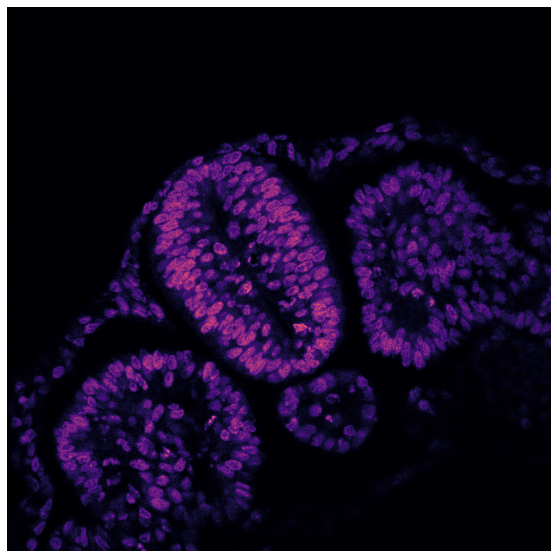

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(im[:,:,0], cmap='magma'); plt.axis('off')

In [13]:
im = np.expand_dims(im, axis=0)
#im =np.moveaxis(im, -1, 0)
im.shape

(1, 1024, 1024, 4)

In [32]:
for input_img in range(48,len(images_to_segment)):
    print(input_img)

47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [14]:
for i in range(0,len(images_to_segment)):
    input_img = images_to_segment[i]
    print(input_img)
    im = io.imread(ROOT_PATH+"img/"+input_img)
    im= im[0:round(im.shape[0]/128)*128, 0:round(im.shape[1]/128)*128,:]
    print(im.shape)
    #im = np.expand_dims(im, axis=0)
    im =np.moveaxis(im, -1, 0)
    print(im.shape)
    #im= im[round(im.shape[0]/128)*128, 0:round(im.shape[1]/128)*128]
    #im= im[0:round(im.shape[0]/128)*128, 0:round(im.shape[1]/128)*128,:]
    #print(im.shape)
    tifffile.imsave(ROOT_PATH+"img/"+'crop'+input_img, im)
    

04-08-22_40x.lif - scram-3 - Z=8.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-4 - Z=7.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-1 - Z=4.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-2 - Z=1.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-4 - Z=2.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-4 - Z=3.tif


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-2 - Z=3.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-1 - Z=5.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-4 - Z=0.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-3 - Z=2.tif (MG).tif
(1024, 1024, 3)
(3, 1024, 1024)
04-08-22_40x.lif - scram-2 - Z=8.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-3 - Z=2.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-1 - Z=0.tif
(1024, 1024, 4)
(4, 1024, 1024)


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


04-08-22_40x.lif - scram-1 - Z=6.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-4 - Z=4.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-4 - Z=3.tif (G).tif
(1024, 1024, 3)
(3, 1024, 1024)
04-08-22_40x.lif - olig2-3 - Z=2.tif (RGB).tif
(1024, 1024, 3)
(3, 1024, 1024)
04-08-22_40x.lif - scram-4 - Z=0.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-1 - Z=4.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-4 - Z=5.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-2 - Z=2.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-3 - Z=4.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-4 - Z=6.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-5 - Z=6.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-5 - Z=1.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-4 - Z=3.tif (RGB).tif


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(1024, 1024, 3)
(3, 1024, 1024)
04-08-22_40x.lif - scram-1 - Z=3.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-1 - Z=1.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-1 - Z=2.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-4 - Z=3.tif (M).tif


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(1024, 1024, 3)
(3, 1024, 1024)
04-08-22_40x.lif - olig2-2 - Z=4.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-3 - Z=10.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-2 - Z=9.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-5 - Z=3.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-2 - Z=0.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-4 - Z=5.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-3 - Z=2.tif


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-3 - Z=3.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-4 - Z=3.tif (MG).tif
(1024, 1024, 3)
(3, 1024, 1024)
04-08-22_40x.lif - olig2-5 - Z=5.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-2 - Z=5.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-3 - Z=9.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-5 - Z=4.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-3 - Z=3.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-5 - Z=2.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-3 - Z=0.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-3 - Z=6.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-1 - Z=1.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-5 - Z=0.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-1 - Z=5.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-1 - Z=3.tif
(1024, 1024, 4)
(4, 1024,

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-2 - Z=5.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-3 - Z=5.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-5 - Z=8.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-2 - Z=3.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-2 - Z=2.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-3 - Z=2.tif (M).tif
(1024, 1024, 3)
(3, 1024, 1024)
04-08-22_40x.lif - scram-3 - Z=4.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-3 - Z=0.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-3 - Z=1.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-1 - Z=0.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-4 - Z=4.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-2 - Z=7.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-3 - Z=2.tif (G).tif


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(1024, 1024, 3)
(3, 1024, 1024)
04-08-22_40x.lif - olig2-3 - Z=6.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-2 - Z=1.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-1 - Z=2.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-3 - Z=7.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-4 - Z=2.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-4 - Z=1.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-1 - Z=7.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-4 - Z=8.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-3 - Z=1.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - olig2-4 - Z=1.tif
(1024, 1024, 4)
(4, 1024, 1024)
04-08-22_40x.lif - scram-3 - Z=5.tif
(1024, 1024, 4)
(4, 1024, 1024)


In [17]:
images_to_segment = os.listdir(ROOT_PATH+"img/")

images_to_segment = [x for x in images_to_segment if ("crop" in x)]

images_to_segment

['crop04-08-22_40x.lif - scram-2 - Z=8.tif',
 'crop04-08-22_40x.lif - scram-3 - Z=9.tif',
 'crop04-08-22_40x.lif - scram-1 - Z=4.tif',
 'crop04-08-22_40x.lif - olig2-3 - Z=4.tif',
 'crop04-08-22_40x.lif - olig2-2 - Z=4.tif',
 'crop04-08-22_40x.lif - olig2-2 - Z=3.tif',
 'crop04-08-22_40x.lif - olig2-5 - Z=2.tif',
 'crop04-08-22_40x.lif - scram-1 - Z=6.tif',
 'crop04-08-22_40x.lif - olig2-5 - Z=8.tif',
 'crop04-08-22_40x.lif - scram-4 - Z=1.tif',
 'crop04-08-22_40x.lif - scram-4 - Z=2.tif',
 'crop04-08-22_40x.lif - olig2-3 - Z=3.tif',
 'crop04-08-22_40x.lif - olig2-3 - Z=6.tif',
 'crop04-08-22_40x.lif - scram-4 - Z=6.tif',
 'crop04-08-22_40x.lif - scram-3 - Z=6.tif',
 'crop04-08-22_40x.lif - olig2-5 - Z=3.tif',
 'crop04-08-22_40x.lif - olig2-3 - Z=1.tif',
 'crop04-08-22_40x.lif - scram-3 - Z=7.tif',
 'crop04-08-22_40x.lif - scram-1 - Z=3.tif',
 'crop04-08-22_40x.lif - scram-2 - Z=1.tif',
 'crop04-08-22_40x.lif - olig2-4 - Z=4.tif',
 'crop04-08-22_40x.lif - scram-3 - Z=0.tif',
 'crop04-0

In [18]:

#for z in tqdm.notebook.tqdm(range(im.shape[0]), desc="z-planes to segment"):
#for z in range(im.shape[0]):
#for z in range(31,74):
#for input_img in images_to_segment:
#for k in range(2,3):
for k in range(0,len(images_to_segment)):    
   
    input_img=images_to_segment[k]
    print("Segmenting image:")
    print(input_img)
    im = io.imread(ROOT_PATH+"img/"+input_img)
    im = np.moveaxis(im, -1, 0)
    print(im.shape)
    

    sz=im[NUCLEAR_Ch,:,:] # im[z,:,:,0] #why this difference? tiff format?
    print(sz.shape)

    # interpolate image to higher size 
#     sz= cv2.resize(sz, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LANCZOS4) # just for predictor
#     im = Image.fromarray(sz) # do not save
#     input_img = input_img+"_mod.tif"
#     im.save(ROOT_PATH+"/img/"+input_img)
#     tifffile.imsave(ROOT_PATH+"img/"+input_img, sz)
#     print(sz.shape)
#     print(input_img)

    
    
    one = ImageInput(img_str=sz, step=256) 
    #one.show_me()



    # split image in tiles for 'stitch_v1' 
    m_tiles, v_tiles, h_tiles = one.make_tiles('stitch_v1')

    #just shows an example
    #m_tiles[4].show_me()

    #print(np.shape(m_tiles[7].img))



    # Predicting for : 'stitch_v1'
    print("Predicting...")

    pred= detectron_init(model='SC_sections') # 'invitro'  or 'SC_sections'

    tic=timeit.default_timer()
    print("Main_tiles")
    m_out = [detectron_predict(_im,pred) for _im in m_tiles] 
    print("V_tiles")
    v_out = [detectron_predict(_im,pred) for _im in v_tiles]
    print("H_tiles")
    h_out = [detectron_predict(_im,pred) for _im in h_tiles]
    toc=timeit.default_timer()
    #print('The time was {:.2f} sec'.format(toc - tic))
    
    
    # Stitching
    print("Stitching...")
    tic=timeit.default_timer()
    test = Stitcher(one)
    seg_mask, nuclei_tally = test.stitch_v1([m_tiles,v_tiles,h_tiles] , [m_out, v_out, h_out], margin=5)
    toc=timeit.default_timer()
    #print('The time was {:.2f} sec'.format(toc - tic))
    #plt.figure(figsize=(8,8))
    #plt.imshow(seg_mask)
    print(f'This image has {nuclei_tally} segmented nuclei.')
    
    
    
    # save mask 
    print("Saving...")
    #im_seg = cv2.resize(seg_mask, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST) #scale mask to fit original input
    #im_seg = Image.fromarray(im_seg)
    im_seg = Image.fromarray(seg_mask)
    #print(im_seg.shape)
    im_seg.save(ROOT_PATH+"masks/"+input_img)
    print("Segm mask saved.")
    
    
    
    # save JSON
    tic=timeit.default_timer()
    PNG_to_JSON.main(ROOT_DIR=ROOT_PATH,
                            image_files=[input_img], 
                            output= ROOT_PATH+"masks/"+ input_img +'_.json') 
    toc=timeit.default_timer()
    print('json saved. The time for saving json was {:.2f} sec'.format(toc - tic))
    
    
    
    
    # save overlay segmentation and image
    segmFile =ROOT_PATH+"masks/"+input_img+'_.json'
    imgDir   = ROOT_PATH+"img/"
    output_imageFile = ROOT_PATH+"masks/z"+input_img+'_coco_out.png'
    pick_image_number=0

    coco=coco_nucleus(segmFile)
    cats = coco.loadCats(coco.getCatIds())
    nms=[cat['name'] for cat in cats]
    print('COCO categories: \n{}\n'.format(' '.join(nms)))
    catIds = coco.getCatIds(catNms=['nucleus']);
    imgIds = coco.getImgIds(catIds=catIds);
    img = coco.loadImgs(imgIds[pick_image_number])[0]

    fig = plt.figure(figsize=(18,18))

    input_img+"_mod.tif"
    I = io.imread(imgDir+img['file_name'])
    I = np.moveaxis(I, -1, 0)
    I = np.asarray(I[NUCLEAR_Ch,:,:]) #[z,:,:,0]


    plt.imshow(I, cmap='magma'); plt.axis('off')
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
    anns = coco.loadAnns(annIds)
    coco.showAnns_Nucleus(anns)
    plt.savefig(output_imageFile,dpi=150,bbox_inches='tight',pad_inches=0)
    plt.close()

    print("saved overlay. All done.")
    print("\n\n\n\n\n")


Segmenting image:
crop04-08-22_40x.lif - scram-2 - Z=8.tif
(4, 1024, 1024)
(1024, 1024)
Using step of 256px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 578 segmented nuclei.
Saving...
Segm mask saved.
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/
None
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/masks/crop04-08-22_40x.lif - scram-2 - Z=8.tif_.json
Supply z-slice of original image. zero if none.
crop04-08-22_40x.lif - scram-2 - Z=8.tif
(1024, 1024, 4)
577
The time for annotation info was 9.27 sec
Done saving JSON!
json saved. The time for saving json was 9.34 sec
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
nucleus

saved overlay. All done.






Segmenting image:
crop04-08-22_40x.lif - scram-3 - Z=9.tif
(4, 1024, 1024)
(1024, 1024)
Using s

Using step of 256px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 485 segmented nuclei.
Saving...
Segm mask saved.
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/
None
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/masks/crop04-08-22_40x.lif - scram-4 - Z=1.tif_.json
Supply z-slice of original image. zero if none.
crop04-08-22_40x.lif - scram-4 - Z=1.tif
(1024, 1024, 4)
485
The time for annotation info was 9.05 sec
Done saving JSON!
json saved. The time for saving json was 9.12 sec
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
nucleus

saved overlay. All done.






Segmenting image:
crop04-08-22_40x.lif - scram-4 - Z=2.tif
(4, 1024, 1024)
(1024, 1024)
Using step of 256px.
Splitting image in main tiles...
Splitting image in vertical border tiles.

Main_tiles
V_tiles
H_tiles
Stitching...
This image has 606 segmented nuclei.
Saving...
Segm mask saved.
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/
None
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/masks/crop04-08-22_40x.lif - scram-1 - Z=1.tif_.json
Supply z-slice of original image. zero if none.
crop04-08-22_40x.lif - scram-1 - Z=1.tif
(1024, 1024, 4)
606
The time for annotation info was 8.70 sec
Done saving JSON!
json saved. The time for saving json was 8.79 sec
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
nucleus

saved overlay. All done.






Segmenting image:
crop04-08-22_40x.lif - scram-3 - Z=8.tif
(4, 1024, 1024)
(1024, 1024)
Using step of 256px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 628 segmented nuclei.
Saving...
Segm mas

The time for annotation info was 9.16 sec
Done saving JSON!
json saved. The time for saving json was 9.23 sec
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO categories: 
nucleus

saved overlay. All done.






Segmenting image:
crop04-08-22_40x.lif - olig2-1 - Z=0.tif
(4, 1024, 1024)
(1024, 1024)
Using step of 256px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 405 segmented nuclei.
Saving...
Segm mask saved.
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/
None
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/masks/crop04-08-22_40x.lif - olig2-1 - Z=0.tif_.json
Supply z-slice of original image. zero if none.
crop04-08-22_40x.lif - olig2-1 - Z=0.tif
(1024, 1024, 4)
405
The time for annotation info was 8.13 sec
Done saving JSON!
json saved. The time for saving jso

saved overlay. All done.






Segmenting image:
crop04-08-22_40x.lif - scram-1 - Z=2.tif
(4, 1024, 1024)
(1024, 1024)
Using step of 256px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 665 segmented nuclei.
Saving...
Segm mask saved.
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/
None
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/masks/crop04-08-22_40x.lif - scram-1 - Z=2.tif_.json
Supply z-slice of original image. zero if none.
crop04-08-22_40x.lif - scram-1 - Z=2.tif
(1024, 1024, 4)
663
The time for annotation info was 9.43 sec
Done saving JSON!
json saved. The time for saving json was 9.51 sec
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO categories: 
nucleus

saved overlay. All done.






Segmenting image:
crop04-08-22_40x.lif - olig2-2 - Z=1.tif
(4, 1

Main_tiles
V_tiles
H_tiles
Stitching...
This image has 553 segmented nuclei.
Saving...
Segm mask saved.
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/
None
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/masks/crop04-08-22_40x.lif - scram-3 - Z=4.tif_.json
Supply z-slice of original image. zero if none.
crop04-08-22_40x.lif - scram-3 - Z=4.tif
(1024, 1024, 4)
553
The time for annotation info was 9.38 sec
Done saving JSON!
json saved. The time for saving json was 9.47 sec
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
nucleus

saved overlay. All done.






Segmenting image:
crop04-08-22_40x.lif - scram-2 - Z=6.tif
(4, 1024, 1024)
(1024, 1024)
Using step of 256px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 563 segmented nuclei.
Saving...
Segm mas

The time for annotation info was 10.06 sec
Done saving JSON!
json saved. The time for saving json was 10.15 sec
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
nucleus

saved overlay. All done.






Segmenting image:
crop04-08-22_40x.lif - scram-4 - Z=3.tif
(4, 1024, 1024)
(1024, 1024)
Using step of 256px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 576 segmented nuclei.
Saving...
Segm mask saved.
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/
None
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/masks/crop04-08-22_40x.lif - scram-4 - Z=3.tif_.json
Supply z-slice of original image. zero if none.
crop04-08-22_40x.lif - scram-4 - Z=3.tif
(1024, 1024, 4)
575
The time for annotation info was 8.98 sec
Done saving JSON!
json saved. The time for saving j

saved overlay. All done.






Segmenting image:
crop04-08-22_40x.lif - olig2-4 - Z=2.tif
(4, 1024, 1024)
(1024, 1024)
Using step of 256px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 631 segmented nuclei.
Saving...
Segm mask saved.
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/
None
/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/masks/crop04-08-22_40x.lif - olig2-4 - Z=2.tif_.json
Supply z-slice of original image. zero if none.
crop04-08-22_40x.lif - olig2-4 - Z=2.tif
(1024, 1024, 4)
629
The time for annotation info was 8.82 sec
Done saving JSON!
json saved. The time for saving json was 8.90 sec
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO categories: 
nucleus

saved overlay. All done.






Segmenting image:
crop04-08-22_40x.lif - scram-4 - Z=4.tif
(4, 1

In [40]:
im = io.imread(ROOT_PATH+"img/"+input_img)
im.shape

(1024, 1388)

# Get Features Table

In [19]:
ROOT_PATH

'/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/'

In [20]:
import pandas as pd
output_table=ROOT_PATH +"features_table.csv"
output_table

'/camp/lab/briscoej/working/Ashley/For_Tiago/HHgRNA_CLE/large_photos/features_table.csv'

In [21]:
input_img = images_to_segment[0]
img = io.imread(ROOT_PATH+"img/"+input_img)
img = np.moveaxis(img, -1, 0)
sz=img

img.shape[0]

4

In [22]:

df=[]

for input_img in images_to_segment:
    #     #input_img = images_to_segment[0]

    print(input_img)
    # # modify to give just a single numpy array
    # img = Image.open(ROOT_PATH+"/img/"+input_img)
    # img_ch = []
    # for i in range(img.n_frames):
    #     img.seek(i)
    #     img_ch.append(np.array(img))
    # img = np.array(img_ch)
    # img = np.moveaxis(img, -1, 0)

    img = io.imread(ROOT_PATH+"img/"+input_img)
    img = np.moveaxis(img, -1, 0)
    sz=img

    #im = np.moveaxis(im, -1, 0)

    #     #open NT_mask
    #     #mask_NT = Image.open(ROOT_PATH+"/NT_masks/"+input_img)
    #     #mask_NT = np.asarray(mask_NT).copy()
    #     #print(mask_NT.flags)
    #     #mask_NT[mask_NT > 0] = 1
    #     #NT_locs = np.where(np.asarray(mask_NT) == 1)

    #     #plt.imshow(mask_NT)

    #     #DV_0=np.min(NT_locs[0]) #y axis
    #     #DV_100=np.max(NT_locs[0])

    #     #ML_0=np.min(NT_locs[1]) #x axis
    #     #ML_100=np.max(NT_locs[1])


    print(sz.shape)


    segmFile =ROOT_PATH+"/masks/"+input_img+'_.json'
    coco=coco_nucleus(segmFile)
    annids = coco.getAnnIds()
    anns = coco.loadAnns(annids)
    print("Number of nuclei:")
    print(len(anns))


    for inst in range(len(anns)):
        #print(inst)
        #print(anns[inst]['id'])
        if (anns[inst]['segmentation']==[]):
            pass
        else:
            mask = coco.annToMask(anns[inst])
            #plt.imshow(mask)
            locs = np.where(mask == 1)
            #rint(len(locs[0]))
            if len(locs[0])>20: #basic filter for very small detections <20 pixels

                #channel nuclear averages
                nuclear_avgs = []
                for i in range(img.shape[0]):
                    nuclear_avgs.append(round(np.mean(img[i][locs]),3))
                
                #shape
                aspect_ratio = round(anns[inst]['bbox'][2]/anns[inst]['bbox'][3],3)


                # centroid coordinates in original image.
                contours,hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                if len(contours)==1:
                    cnt = contours[0]
                else:
                    print("strange mask with >1 contours")
                    print(anns[inst]['id'])
                    xi=0
                    xi_len=len(contours[xi])

                    for i in range(len(contours)): 
                        if len(contours[i])>xi_len:
                            xi=i
                            cnt = contours[i]
                M = cv2.moments(cnt)
                #print(M)
                if M['m00']==0:
                    pass
                else:
                    cx = int(M['m10']/M['m00'])    
                    cy = int(M['m01']/M['m00'])
                    area = cv2.contourArea(cnt)
                    if len(cnt)>5: # ensures there are enough points to call elipse
                        (x,y),(MA,ma), angle = cv2.fitEllipse(cnt)
                    else:
                        (x,y),(MA,ma), angle = (np.nan,np.nan),(np.nan,np.nan), np.nan


                #get info on hood
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
                mask_hood = cv2.dilate(mask, kernel, iterations=20)    
                locs = np.where(mask_hood == 1)
                #channel averages
                hood_avgs = []
                for i in range(img.shape[0]):
                    hood_avgs.append(round(np.mean(img[i][locs]),3))


                #get info on immediate hood ~ cytoplasm ideally?
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
                mask_cyto = cv2.dilate(mask, kernel, iterations=6)
                mask_cyto = mask_cyto - mask   
                locs = np.where(mask_cyto == 1)
                #channel averages
                cyto_avgs = []
                for i in range(img.shape[0]):
                    cyto_avgs.append(round(np.mean(img[i][locs]),3))


                df.append( (input_img, anns[inst]['id'],nuclear_avgs,
                            anns[inst]['area'],area ,aspect_ratio, 
                            (x,y),(MA,ma), angle, 
                            (cx,cy),
                            hood_avgs,
                           cyto_avgs)  )



Data = pd.DataFrame(df, columns=('Image', 'Instance', 'nuclear_avgs',
                     'Bbox area', 'area','Aspect_ratio','Elipse_centre','Elipse_major_minor','Elipse_angle',
                             'Centroid',
                            'hood_avgs',
                            'cyto_avgs'))

Data.to_csv(output_table, index=False)

Data

crop04-08-22_40x.lif - scram-2 - Z=8.tif
(4, 1024, 1024)
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Number of nuclei:
576
strange mask with >1 contours
247
strange mask with >1 contours
272
strange mask with >1 contours
485
crop04-08-22_40x.lif - scram-3 - Z=9.tif
(4, 1024, 1024)
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Number of nuclei:
547
strange mask with >1 contours
299
crop04-08-22_40x.lif - scram-1 - Z=4.tif
(4, 1024, 1024)
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Number of nuclei:
681
strange mask with >1 contours
23
strange mask with >1 contours
53
strange mask with >1 contours
446
crop04-08-22_40x.lif - olig2-3 - Z=4.tif
(4, 1024, 1024)
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of nuclei:
890
strange mask with >1 contours
77
strange mask with >1 contours
115
strange mask with >1 contours
119
strange mask wi

strange mask with >1 contours
131
strange mask with >1 contours
172
strange mask with >1 contours
204
strange mask with >1 contours
512
strange mask with >1 contours
597
strange mask with >1 contours
605
strange mask with >1 contours
607
crop04-08-22_40x.lif - scram-2 - Z=7.tif
(4, 1024, 1024)
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Number of nuclei:
568
strange mask with >1 contours
454
strange mask with >1 contours
488
crop04-08-22_40x.lif - scram-2 - Z=2.tif
(4, 1024, 1024)
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of nuclei:
458
strange mask with >1 contours
205
strange mask with >1 contours
295
strange mask with >1 contours
325
strange mask with >1 contours
327
strange mask with >1 contours
330
strange mask with >1 contours
331
strange mask with >1 contours
344
strange mask with >1 contours
397
strange mask with >1 contours
407
crop04-08-22_40x.lif - olig2-3 - Z=0.tif
(4, 1024, 1024)
loading

Done (t=0.11s)
creating index...
index created!
Number of nuclei:
552
strange mask with >1 contours
94
strange mask with >1 contours
150
strange mask with >1 contours
160
strange mask with >1 contours
283
strange mask with >1 contours
289
strange mask with >1 contours
462
strange mask with >1 contours
516
strange mask with >1 contours
518
crop04-08-22_40x.lif - scram-2 - Z=6.tif
(4, 1024, 1024)
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of nuclei:
559
strange mask with >1 contours
218
strange mask with >1 contours
242
strange mask with >1 contours
262
strange mask with >1 contours
414
strange mask with >1 contours
492
strange mask with >1 contours
495
strange mask with >1 contours
529
strange mask with >1 contours
550
crop04-08-22_40x.lif - olig2-2 - Z=0.tif
(4, 1024, 1024)
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Number of nuclei:
434
strange mask with >1 contours
186
strange mask with >1 contours

,Image,Instance,nuclear_avgs,Bbox area,area,Aspect_ratio,Elipse_centre,Elipse_major_minor,Elipse_angle,Centroid,hood_avgs,cyto_avgs
0,crop04-08-22_40x.lif - scram-2 - Z=8.tif,1,"[50.941, 11.899, 38.647, 3.054]",762,698.0,1.167,"(197.30709838867188, 202.91107177734375)","(23.310813903808594, 39.94140625)",58.402843,"(196, 203)","[26.104, 8.621, 35.749, 3.11]","[26.307, 8.667, 40.629, 3.888]"
1,crop04-08-22_40x.lif - scram-2 - Z=8.tif,2,"[42.266, 8.748, 33.927, 2.263]",664,589.5,0.933,"(86.63372039794922, 96.123291015625)","(26.60247039794922, 30.114809036254883)",160.280136,"(86, 96)","[18.453, 5.664, 27.967, 1.959]","[18.291, 6.486, 32.995, 2.625]"
2,crop04-08-22_40x.lif - scram-2 - Z=8.tif,3,"[43.465, 9.833, 37.538, 3.085]",680,603.5,1.308,"(148.13845825195312, 163.90509033203125)","(26.424503326416016, 32.420692443847656)",78.495544,"(148, 164)","[24.491, 7.62, 32.363, 2.509]","[27.902, 8.168, 35.733, 2.925]"
3,crop04-08-22_40x.lif - scram-2 - Z=8.tif,4,"[50.36, 12.073, 35.18, 2.72]",192,122.0,3.000,"(146.34820556640625, 1.0160460472106934)","(13.032010078430176, 24.848493576049805)",88.049019,"(146, 3)","[30.439, 9.178, 37.155, 2.863]","[27.078, 9.616, 39.066, 2.492]"
4,crop04-08-22_40x.lif - scram-2 - Z=8.tif,5,"[30.254, 8.318, 36.806, 2.985]",213,178.0,0.889,"(43.37368392944336, 27.5627384185791)","(14.898202896118164, 17.099597930908203)",174.394714,"(43, 27)","[20.143, 7.131, 30.566, 2.311]","[10.819, 6.638, 31.589, 2.71]"
...,...,...,...,...,...,...,...,...,...,...,...,...
42429,crop04-08-22_40x.lif - scram-3 - Z=10.tif,425,"[6.373, 2.233, 14.088, 0.408]",496,433.0,1.500,"(529.28662109375, 749.8580932617188)","(18.80535316467285, 40.54351806640625)",76.787674,"(530, 748)","[5.162, 1.866, 13.856, 0.495]","[7.013, 2.399, 13.983, 0.454]"
42430,crop04-08-22_40x.lif - scram-3 - Z=10.tif,426,"[7.181, 1.922, 12.53, 0.448]",559,515.5,2.105,"(573.6704711914062, 760.029541015625)","(16.35749053955078, 43.79319763183594)",94.536942,"(574, 760)","[4.492, 1.645, 13.273, 0.401]","[4.473, 2.583, 13.743, 0.429]"
42431,crop04-08-22_40x.lif - scram-3 - Z=10.tif,427,"[9.93, 3.312, 17.118, 0.768]",858,754.0,1.692,"(718.5194091796875, 753.11328125)","(24.967239379882812, 54.662628173828125)",89.560303,"(719, 752)","[3.78, 2.063, 15.2, 0.619]","[6.264, 3.039, 18.118, 0.973]"
42432,crop04-08-22_40x.lif - scram-3 - Z=10.tif,428,"[8.864, 2.149, 12.992, 0.357]",512,423.0,3.286,"(530.289794921875, 761.0121459960938)","(12.675485610961914, 47.0352668762207)",94.950569,"(530, 761)","[5.245, 1.965, 13.996, 0.515]","[4.738, 1.79, 13.975, 0.454]"


In [23]:
Data.to_csv(output_table, index=False)

In [24]:
print("DONE!")

DONE!


In [ ]:
# check cytoplasm/ hood mask


print(input_img)

img = io.imread(ROOT_PATH+"img/"+input_img)
img = np.moveaxis(img, -1, 0)
sz=img
    
print(sz.shape)


segmFile =ROOT_PATH+"/masks/"+input_img+'_.json'
coco=coco_nucleus(segmFile)
annids = coco.getAnnIds()
anns = coco.loadAnns(annids)
print("Number of nuclei:")
print(len(anns))

inst= 105

print(anns[inst]['segmentation'])

mask = coco.annToMask(anns[inst])
#plt.imshow(mask)
locs = np.where(mask == 1)
#rint(len(locs[0]))
if len(locs[0])>20: #basic filter for very small detections <20 pixels

    #channel averages
    ch1_avg = round(np.mean(img[0][locs]),3) 
    ch2_avg = round(np.mean(img[1][locs]),3)
    ch3_avg = round(np.mean(img[2][locs]),3)
    ch4_avg = round(np.mean(img[3][locs]),3) # can add if to check if there are these many channels

    #shape
    aspect_ratio = round(anns[inst]['bbox'][2]/anns[inst]['bbox'][3],3)


    # centroid coordinates in original image.
    contours,hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours)==1:
        cnt = contours[0]
    else:
        print("strange mask with >1 contours")
        print(anns[inst]['id'])
        xi=0
        xi_len=len(contours[xi])

        for i in range(len(contours)): 
            if len(contours[i])>xi_len:
                xi=i
                cnt = contours[i]
    M = cv2.moments(cnt)
    #print(M)
    cx = int(M['m10']/M['m00'])    
    cy = int(M['m01']/M['m00'])
    area = cv2.contourArea(cnt)
    if len(cnt)>5: # ensures there are enough points to call elipse
        (x,y),(MA,ma), angle = cv2.fitEllipse(cnt)
    else:
        (x,y),(MA,ma), angle = (np.nan,np.nan),(np.nan,np.nan), np.nan


    #get info on hood
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask_hood = cv2.dilate(mask, kernel, iterations=10)    
    locs = np.where(mask_hood == 1)
    #channel averages
    ch1_avg_hood = round(np.mean(img[0][locs]),3) 
    ch2_avg_hood = round(np.mean(img[1][locs]),3)
    ch3_avg_hood = round(np.mean(img[2][locs]),3)
    ch4_avg_hood = round(np.mean(img[3][locs]),3) # can add if to check if there are these many channels


    #get info on immediate hood ~ cytoplasm ideally?
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask_cyto = cv2.dilate(mask, kernel, iterations=6)
    mask_cyto = mask_cyto - mask   
    locs = np.where(mask_cyto == 1)
    #channel averages
    ch1_avg_cyto = round(np.mean(img[0][locs]),3) 
    ch2_avg_cyto = round(np.mean(img[1][locs]),3)
    ch3_avg_cyto = round(np.mean(img[2][locs]),3)
    ch4_avg_cyto = round(np.mean(img[3][locs]),3) # can add if to check if there are these many channels

    
    
    locs = np.where(mask_hood == 1)


    #locs = np.where(mask_cyto == 1)

    plt.figure(figsize=(15,15))
    plt.imshow(img[0,:,:], cmap='Greys_r')
    plt.scatter(locs[1],locs[0],alpha=0.05,c='red',s=1)


In [ ]:
output_table = '/camp/lab/briscoej/working/tiago/nucleus_t18/Nucleus/notebooks/Joaquina/IP-jsbh208_1fA_003-1.tiffeatures_table.csv'

In [ ]:
import ast
df=pd.read_csv(output_table, converters={"Centroid": ast.literal_eval})
df

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(231)
plt.hist(df['Ch1_avg_signal'], 100, density=True, facecolor='black', alpha=0.95)
plt.title('Ch1 - DAPI')
plt.subplot(232)
plt.hist(df['Ch2_avg_signal'], 100, density=True, facecolor='black', alpha=0.95)
plt.title('Ch2 - 647')
plt.subplot(233)
plt.hist(df['Ch3_avg_signal'], 100, density=True, facecolor='black', alpha=0.95)
plt.title('Ch3 - 488')

plt.subplot(234)
plt.hist(df['Ch4_avg_signal'], 100, density=True, facecolor='black', alpha=0.95)
plt.title('Ch4 - 594')
#plt.subplot(235)
#plt.hist(df['ch5_cell_avg'], 100, density=True, facecolor='black', alpha=0.95)
#plt.title('Ch5 - 514')
#plt.subplot(236)